In [20]:
import sys
sys.path.append('../')
from TMM_functions import PQ_matrices as pq
from TMM_functions import scatter_matrices as sm
from TMM_functions import redheffer_star as rs
from TMM_functions import generate_initial_conditions as ic
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import cond
import cmath;
from scipy import linalg as LA
from numpy.linalg import solve as bslash
import time
from convolution_matrices.convmat1D import *
# from RCWA_1D_functions.grating_fft.grating_conv import *

# Moharam et. al Formulation for stable and efficient implementation for RCWA
plt.close("all")
'''
'''
L0 = 1e-6;
e0 = 8.854e-12;
mu0 = 4*np.pi*1e-8;

n_ridge = 3.48;              # ridge
n_groove = 3.48;                # groove (unit-less)
lattice_constant = 0.7;  # SI units

## simulation parameters
theta = (0)*np.pi/180;
phi = (0)*np.pi/180;
e_r = 1;
m_r = 1;
e_t = 1;
m_t = 1;
n_i = np.sqrt(e_r);

normal_vector= [0,0,-1]
e_r = 12; m_r = 1;
exy = 14; eyx = 14;
I = np.matrix(np.eye(2))

## specify the initial kx and ky
k0=1
kx = k0 *np.sin(theta)*np.cos(phi);
ky = k0 *np.sin(theta)*np.sin(phi);
print(kx, ky)

0.0 0.0


In [21]:
## redefined functions 
def Pa(kx, ky, e_r, m_r, exy, eyx):
        return (1/e_r)*np.matrix([[kx * ky - exy,  m_r * e_r - kx ** 2],
                                  [ky ** 2 - m_r * e_r,  -kx * ky -exy]]);

def Qa(kx, ky, e_r, m_r):
        Q = (1/m_r)*np.matrix([[kx * ky, (m_r * e_r) - kx ** 2],
                               [ky ** 2 - (m_r * e_r), -kx * ky]]);
        return Q;

def Pa_Qa_kz(kx, ky, e_r, mu_r, exy, eyx):
    '''
    r is for relative so do not put epsilon_0 or mu_0 here
    :param kx:
    :param ky:
    :param e_r:
    :param mu_r:
    :return:
    '''
    # eigensolution required in xy anisotropic medium, yea because the k-axes are now different.
    kz = np.sqrt(mu_r * e_r - kx ** 2 - ky ** 2);
    q = Qa(kx, ky, e_r, mu_r)
    p = Pa(kx, ky, e_r, mu_r, exy, eyx)

    return p, q, kz;    

## Troubleshooting and Observations
In the isotropic case, the E modes can be assumed to be the identity matrix because PQ in that case would actually come out to be the identity matrix.

\begin{equation}
\frac{1}{\mu \epsilon}
\begin{bmatrix}
    k_x k_y & \mu \epsilon - k_x^2 \\
    k_y^2 - \mu\epsilon & -k_x k_y
\end{bmatrix} \begin{bmatrix}
    k_x k_y & \mu \epsilon - k_x^2 \\
    k_y^2 - \mu\epsilon & -k_x k_y
\end{bmatrix} = \begin{bmatrix}
    (-k_x^2 -k_y^2) - \mu \epsilon & 0 \\
    0 & (-k_x^2 -k_y^2) - \mu \epsilon 
\end{bmatrix}
\end{equation}

In the anisotropic case, it is quite clear that the P and Q matrices do not have symmetry with resepct to each other anymore.
\begin{equation}
\frac{1}{\mu \epsilon}
\begin{bmatrix}
    k_x k_y - e_{xy} & \mu \epsilon - k_x^2 \\
    k_y^2 - \mu\epsilon & -k_x k_y + e_{xy}
\end{bmatrix} \begin{bmatrix}
    k_x k_y & \mu \epsilon - k_x^2 \\
    k_y^2 - \mu\epsilon & -k_x k_y
\end{bmatrix} = \begin{bmatrix}
    (-k_x^2 -k_y^2) - \mu \epsilon & 0 \\
    0 & (-k_x^2 -k_y^2) - \mu \epsilon 
\end{bmatrix}
\end{equation}


In [22]:
ref = [];
trans = [];
I = np.matrix(np.eye(2, 2));  # unit 2x2 matrix
wavelengths = np.linspace(0.5, 2, 100)
[e_r, m_r] = [1,1];
[e_t, m_t] = [1,1];
ER = [12];
UR = [1]
layer_thicknesses = [0.5]
n_i = np.sqrt(e_r*m_r);
kx = n_i * np.sin(theta) * np.cos(phi);  # constant in ALL LAYERS; kx = 0 for normal incidence
ky = n_i * np.sin(theta) * np.sin(phi);  # constant in ALL LAYERS; ky = 0 for normal incidence
normal_vector = np.array([0, 0, -1])  # positive z points down;
ate_vector = np.matrix([0, 1, 0]);  # vector for the out of plane E-field

## =================  specify gap media ========================##
e_h = 1; m_h = 1;
Pg, Qg, kzg = pq.P_Q_kz(kx, ky, e_h, m_h)
Wg = I;  # Wg should be the eigenmodes of the E field, which paparently is the identity, yes for a homogeneous medium
sqrt_lambda = cmath.sqrt(-1) * Wg;
# remember Vg is really Qg*(Omg)^-1; Vg is the eigenmodes of the H fields
Vg = Qg * Wg * (sqrt_lambda) ** -1;

## ========================================== ##

[pte, ptm] = [1,0];

for i in range(len(wavelengths)):  # in SI units
    ## initialize global scattering matrix: should be a 4x4 identity so when we start the redheffer star, we get I*SR

    Sg11 = np.matrix(np.zeros((2, 2)));
    Sg12 = np.matrix(np.eye(2, 2));
    Sg21 = np.matrix(np.eye(2, 2));
    Sg22 = np.matrix(np.zeros((2, 2)));  # matrices
    Sg = np.block(
        [[Sg11, Sg12], [Sg21, Sg22]]);  # initialization is equivelant as that for S_reflection side matrix

    ### ================= Working on the Reflection Side =========== ##
    Pr, Qr, kzr = pq.P_Q_kz(kx, ky, e_r, m_r)

    ## ============== values to keep track of =======================##
    S_matrices = list();
    kz_storage = [kzr];
    X_storage = list();
    ## ==============================================================##

    # define vacuum wavevector k0
    lam0 = wavelengths[i];  # k0 and lam0 are related by 2*pi/lam0 = k0
    k0 = 2*np.pi/lam0;
    ## modes of the layer
    Om_r = np.matrix(cmath.sqrt(-1) * kzr * I);
    X_storage.append(Om_r);
    W_ref = I;
    V_ref = Qr * Om_r.I;  # can't play games with V like with W because matrices for V are complex

    ## calculating A and B matrices for scattering matrix
    Ar, Br = sm.A_B_matrices(Wg, W_ref, Vg, V_ref);

    S_ref, Sr_dict = sm.S_R(Ar, Br);  # scatter matrix for the reflection region
    S_matrices.append(S_ref);
    Sg, D_r, F_r = rs.RedhefferStar(Sg, S_ref);

    ## go through the (ANISOTROPIC) layers
    for i in range(len(ER)):
        # ith layer material parameters
        e = ER[i];
        m = UR[i];
        
        # longitudinal k_vector
        P, Q, kzl = Pa_Qa_kz(kx, ky, e, m, exy, eyx)

        ## E-field modes that can propagate in the medium
        W_i = I; #should not be identity for xy anisotorpy
        ## corresponding H-field modes.
        Om = cmath.sqrt(-1) * kzl * I;
        X_storage.append(Om)
        V_i = Q * np.linalg.inv(Om);

        # now defIne A and B
        A, B = sm.A_B_matrices(Wg, W_i, Vg, V_i);

        # calculate scattering matrix
        S_layer, Sl_dict = sm.S_layer(A, B, layer_thicknesses[i], k0, Om)
        S_matrices.append(S_layer);

        ## update global scattering matrix using redheffer star
        Sg, D_i, F_i = rs.RedhefferStar(Sg, S_layer);

    ##========= Working on the Transmission Side==============##
    Pt, Qt, kz_trans = pq.P_Q_kz(kx, ky, e_t, m_t);
    kz_storage.append(kz_trans);

    Om = cmath.sqrt(-1) * kz_trans * I;
    Vt = Qt * np.linalg.inv(Om);

    # get At, Bt
    At, Bt = sm.A_B_matrices(Wg, I, Vg, Vt)

    ST, ST_dict = sm.S_T(At, Bt)
    S_matrices.append(ST);
    # update global scattering matrix
    Sg, D_t, F_t = rs.RedhefferStar(Sg, ST);

    K_inc_vector = n_i * k0 * np.matrix([np.sin(theta) * np.cos(phi), \
                                         np.sin(theta) * np.sin(phi), np.cos(theta)]);

    # cinc is the c1+
    E_inc, cinc, Polarization = ic.initial_conditions(K_inc_vector, theta, normal_vector, pte, ptm)

    ## COMPUTE FIELDS
    Er = Sg[0:2, 0:2] * cinc;  # S11; #(cinc = initial mode amplitudes), cout = Sg*cinc; #2d because Ex, Ey...
    Et = Sg[2:, 0:2] * cinc;  # S21

    Er = np.squeeze(np.asarray(Er));
    Et = np.squeeze(np.asarray(Et));

    Erx = Er[0];
    Ery = Er[1];
    Etx = Et[0];
    Ety = Et[1];

    # apply the grad(E) = 0 equation to get z components
    Erz = -(kx * Erx + ky * Ery) / kzr;
    Etz = -(kx * Etx + ky * Ety) / kz_trans;  ## using divergence of E equation here

    # add in the Erz component to vectors
    Er = np.matrix([Erx, Ery, Erz]);  # a vector
    Et = np.matrix([Etx, Ety, Etz]);

    R = np.linalg.norm(Er) ** 2;
    T = np.linalg.norm(Et) ** 2;
    ref.append(R);
    trans.append(T);

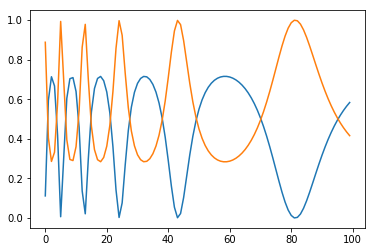

In [23]:
ref = np.array(ref);
trans = np.array(trans);
plt.plot(ref)
plt.plot(trans)
plt.show()